## **Imports**

In [16]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Github Repos/transfer_learning')

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import RandomFlip, RandomRotation
import numpy as np
import matplotlib.pyplot as plt

## **Load Data**

In [17]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"

train_dataset = image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [18]:
class_names = train_dataset.class_names
print("Classes:", class_names)

for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels:", labels.numpy())

Classes: ['alpaca', 'not alpaca']
Batch shape: (32, 160, 160, 3)
Labels: [1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1]


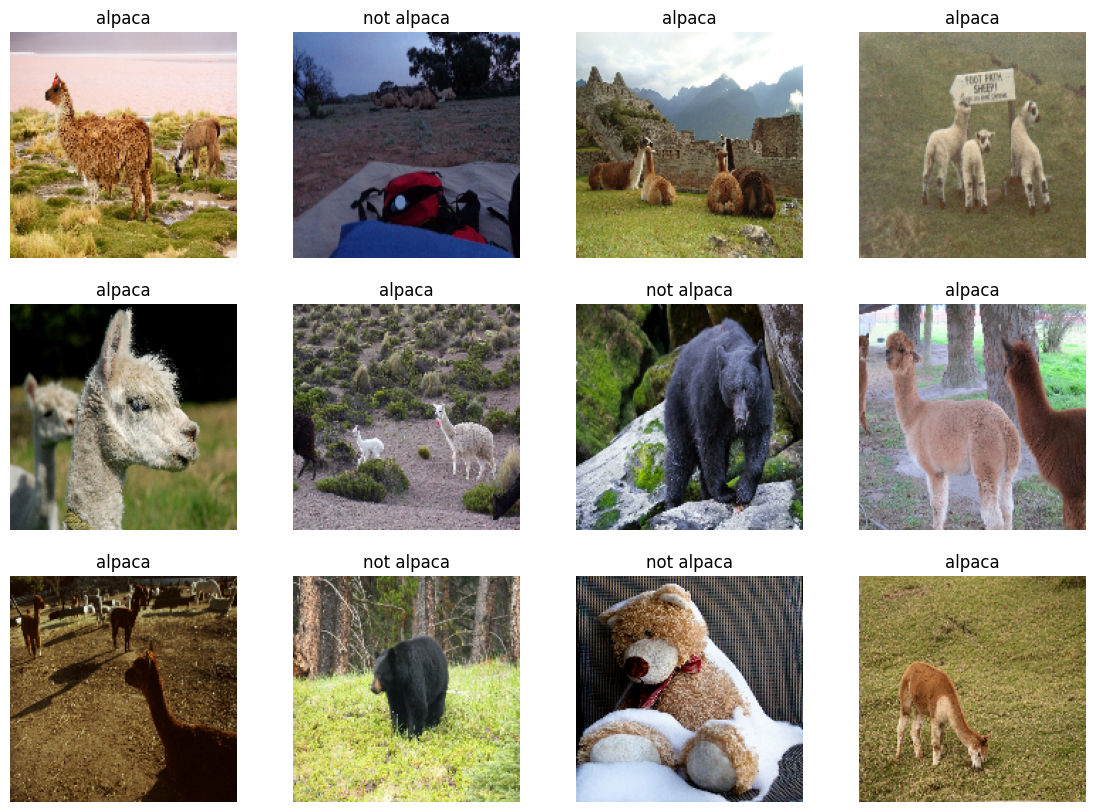

In [19]:
plt.figure(figsize=(14, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## **Data Augmentation**

In [20]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmenter = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2)
    ])
    return data_augmenter

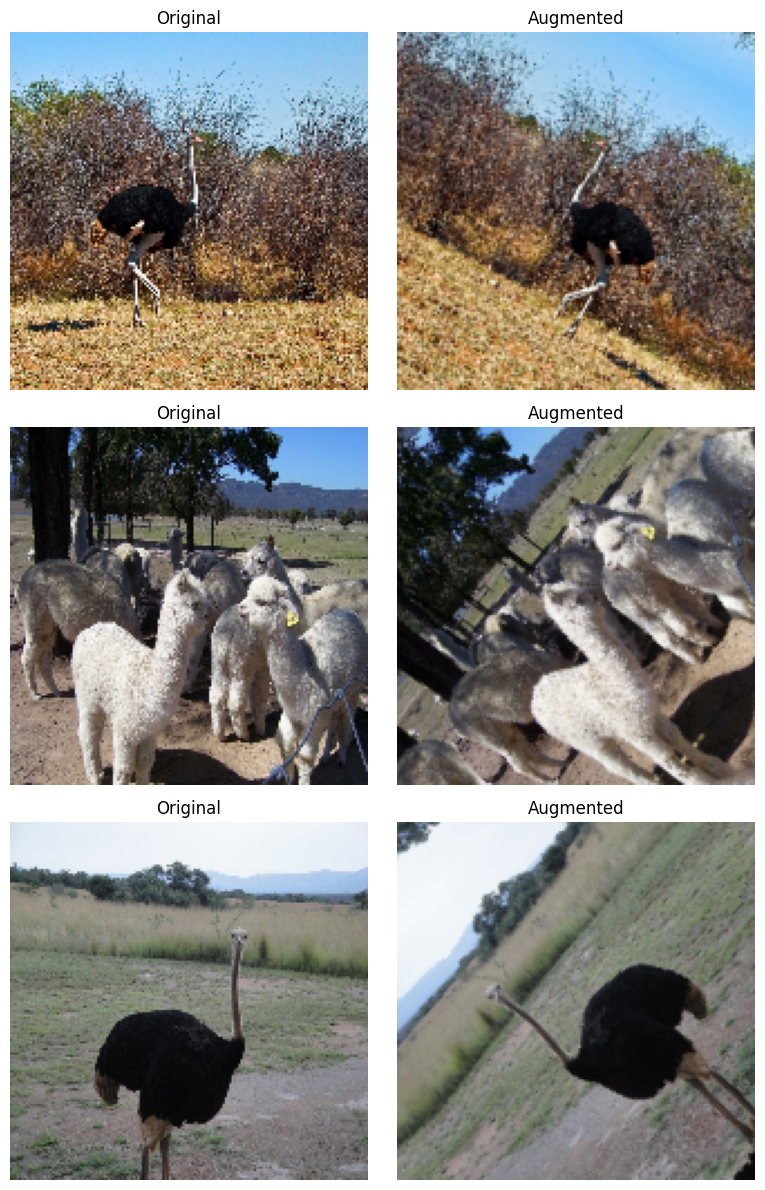

In [21]:
augmenter = data_augmenter()

plt.figure(figsize=(8, 12))
for images, labels in train_dataset.take(1):
    for i in range(3):
        original = images[i]
        augmented = augmenter(tf.expand_dims(original, 0))[0]

        # original image
        ax = plt.subplot(3, 2, 2 * i + 1)
        plt.imshow(original / 255.0)
        plt.title("Original")
        plt.axis("off")

        # augmented image
        ax = plt.subplot(3, 2, 2 * i + 2)
        plt.imshow(augmented / 255.0)
        plt.title("Augmented")
        plt.axis("off")

plt.tight_layout()
plt.show()


## **Model Training and Transfer Learning**

In [74]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),   # (160, 160, 3)
                                               include_top=True,
                                               weights='imagenet')

In [75]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [76]:
all_layers = len(base_model.layers)
print(base_model.layers[all_layers - 3].name)
print(base_model.layers[all_layers - 2].name)
print(base_model.layers[all_layers - 1].name)

out_relu
global_average_pooling2d_3
predictions


In [77]:
images, labels = next(iter(train_dataset))
print("Images batch shape:", images.shape)
print("Labels shape:", labels.shape)
feat_batch = base_model(images)
print("Features shape:", feat_batch.shape)

Images batch shape: (32, 160, 160, 3)
Labels shape: (32,)
Features shape: (32, 1000)


In [78]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    """ Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image shape (H, W)
        data_augmentation -- data augmentation function
    Returns:
    model -- tf.keras model (compiled)
    """

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    # freeze the base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # training=False to avoid updating batch norm statistics
    x = base_model(x, training=False)

    # new binary classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # prediction layer with 1 unit for binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [79]:
model = alpaca_model(IMG_SIZE, data_augmenter())
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [80]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', 'precision', 'recall'])

In [81]:
init_epochs = 5
history = model.fit(train_dataset,
                    epochs=init_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 730ms/step - accuracy: 0.5342 - loss: 0.8187 - precision: 0.5932 - recall: 0.5527 - val_accuracy: 0.6154 - val_loss: 0.7014 - val_precision: 0.5854 - val_recall: 0.7500
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.6767 - loss: 0.6560 - precision: 0.6895 - recall: 0.7849 - val_accuracy: 0.7385 - val_loss: 0.5591 - val_precision: 0.7273 - val_recall: 0.7500
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.7701 - loss: 0.5220 - precision: 0.7780 - recall: 0.8515 - val_accuracy: 0.7538 - val_loss: 0.5032 - val_precision: 0.7353 - val_recall: 0.7812
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - accuracy: 0.8085 - loss: 0.4213 - precision: 0.8180 - recall: 0.8692 - val_accuracy: 0.8154 - val_loss: 0.4403 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.8492 - loss: 0.3831 - precision: 0.9122 - recall: 0.8184 - val_accuracy: 0.8308 - val_loss: 0.4040 - val_pre

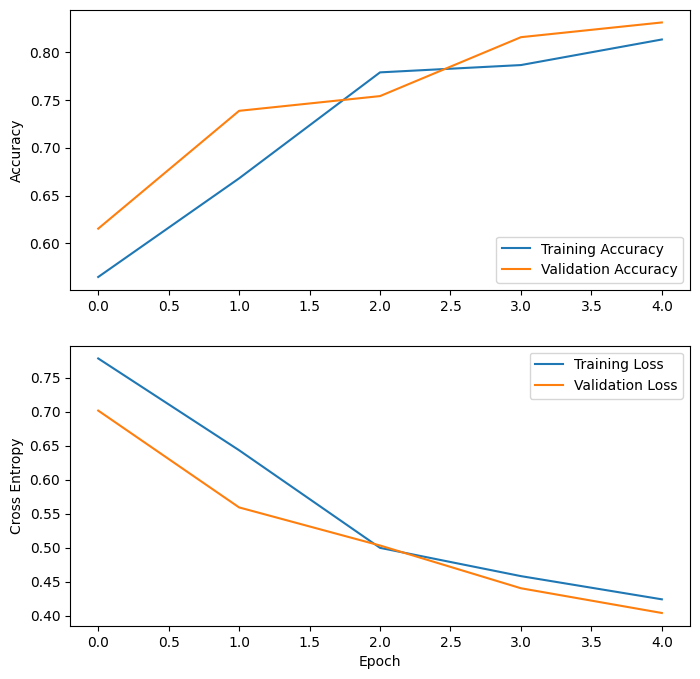

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

## **Fine-tuning the Model**

In [83]:
print("Layers in the model:\n")
for layer in model.layers:
    print(layer.name)

Layers in the model:

input_layer_10
sequential_6
mobilenetv2_1.00_160
global_average_pooling2d_4
dropout_2
dense_2


In [84]:
base_model = model.layers[2]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [86]:
fine_tune_at = 120

In [87]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[2].layers[:fine_tune_at]:
    layer.trainable = False

In [91]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=[
              tf.keras.metrics.BinaryAccuracy(name='accuracy'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')])

In [92]:
fine_tune_epochs = 5
total_epochs =  init_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 649ms/step - accuracy: 0.7613 - loss: 0.4611 - precision: 0.7587 - recall: 0.8727 - val_accuracy: 0.8769 - val_loss: 0.3035 - val_precision: 0.9000 - val_recall: 0.8438
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.9337 - loss: 0.2364 - precision: 0.9268 - recall: 0.9622 - val_accuracy: 0.8769 - val_loss: 0.2773 - val_precision: 0.9000 - val_recall: 0.8438
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.9559 - loss: 0.1797 - precision: 0.9640 - recall: 0.9618 - val_accuracy: 0.8769 - val_loss: 0.2835 - val_precision: 0.9000 - val_recall: 0.8438
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 491ms/step - accuracy: 0.9342 - loss: 0.1677 - precision: 0.9449 - recall: 0.9483 - val_accuracy: 0.8769 - val_loss: 0.2956 - val_precision: 0.9000 - val_recall: 0.8438
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.9859 - loss: 0.0958 - precision: 0.9853 - recall: 0.9908 - val_accuracy: 0.8923 - val_loss: 0.2713 - va

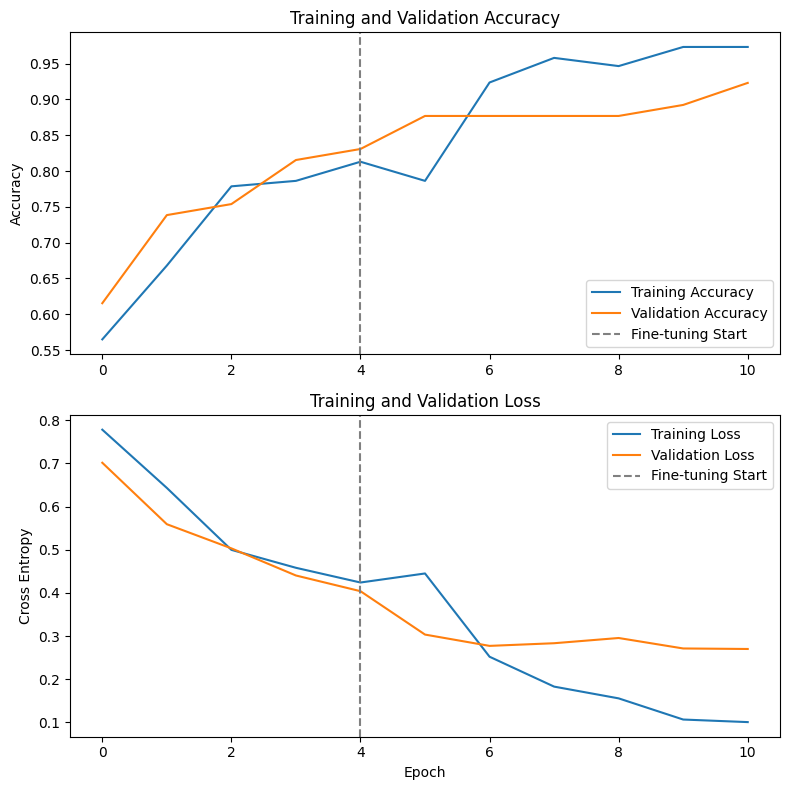

In [96]:
# Combine training and fine-tuning metrics and ploting
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']) - 1, color='gray', linestyle='--', label='Fine-tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']) - 1, color='gray', linestyle='--', label='Fine-tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Final Training Metrics (last epoch):
Accuracy:  0.9733
Loss:      0.1008
Precision: 0.9740
Recall:    0.9804

Final Validation Metrics (last epoch):
Val Accuracy:  0.9231
Val Loss:      0.2701
Val Precision: 0.9091
Val Recall:    0.9375


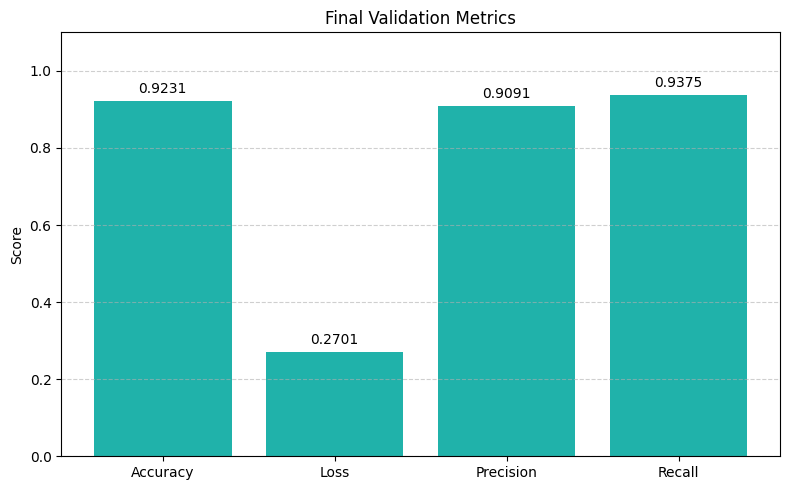

In [98]:
final_acc = history_fine.history['accuracy'][-1]
final_val_acc = history_fine.history['val_accuracy'][-1]

final_loss = history_fine.history['loss'][-1]
final_val_loss = history_fine.history['val_loss'][-1]

final_precision = history_fine.history['precision'][-1]
final_val_precision = history_fine.history['val_precision'][-1]

final_recall = history_fine.history['recall'][-1]
final_val_recall = history_fine.history['val_recall'][-1]

print("Final Training Metrics (last epoch):")
print(f"Accuracy:  {final_acc:.4f}")
print(f"Loss:      {final_loss:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")

print("\nFinal Validation Metrics (last epoch):")
print(f"Val Accuracy:  {final_val_acc:.4f}")
print(f"Val Loss:      {final_val_loss:.4f}")
print(f"Val Precision: {final_val_precision:.4f}")
print(f"Val Recall:    {final_val_recall:.4f}")

labels = ['Accuracy', 'Loss', 'Precision', 'Recall']
val_metrics = [final_val_acc, final_val_loss, final_val_precision, final_val_recall]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, val_metrics, color='lightseagreen')
plt.ylim(0, 1.1 if max(val_metrics) <= 1.0 else max(val_metrics) + 0.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.4f}', ha='center')

plt.title("Final Validation Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()